### Считывание данных

In [ ]:
import yadisk # https://pypi.org/project/yadisk/
import os
from dotenv import load_dotenv

import cv2 # https://docs.opencv.org/4.x/d1/dc5/tutorial_background_subtraction.html
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import colors

import pickle
import json 

from tqdm import tqdm
import time
from pprint import pprint

from collections import Counter

In [2]:
load_dotenv()
TOKEN = os.getenv('DEBUG_TOKEN')
client = yadisk.Client(token=TOKEN)

with client:
    # Проверяет, валиден ли токен
    print(client.check_token())

    # Выводит содержимое "disk:/SLR Project"
    files = list(client.listdir("disk:/SLR Project"))
    print(len(files))

True
482


In [11]:
def read_and_explore(path_on_disk, path_to_save):
    TOKEN = os.getenv('DEBUG_TOKEN')
    client = yadisk.Client(token=TOKEN)
    client.download(path_on_disk, path_to_save) # скачиваем файл
    cap = cv2.VideoCapture(path_to_save) # читаем файл

    # frames = [] # моя оперативка не тянет хранить все фреймы одного видео
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    mean = None # BGR
    std = None # BGR
    frame_thousand = None # BGR
    while cap.isOpened():
        cap.set(cv2.CAP_PROP_POS_FRAMES, min(1000, frames-1))
        ret, frame = cap.read()
        #frames += 1

        # if frames == 1000:
        #     # это всё компьютационно дорогие штуки, 
        #     # будем делать их для каждого видео на кадре 1000
        #     frame_thousand = frame
        #     mean = np.mean(frame.reshape(frame.shape[0]*frame.shape[1], 3), axis=0)
        #     std = np.std(frame.reshape(frame.shape[0]*frame.shape[1], 3), axis=0)
        #     break

        if not ret:
            break
        
        frame_thousand = frame
        mean = np.mean(frame.reshape(frame.shape[0]*frame.shape[1], 3), axis=0)
        std = np.std(frame.reshape(frame.shape[0]*frame.shape[1], 3), axis=0)
        break

    cap.release() # закрываем файл

    # сохраняем 1000-ый фрейм
    with open(f'1000_frames/{path_to_save.split(".")[0]}.pkl', 'wb') as f:
        pickle.dump([frames, fps, mean, std, frame_thousand], f)

    os.remove(path_to_save) # удаляем файл

    return frames, fps, mean, std, frame_thousand

In [ ]:
no_subs_set = set() # видео без субтитров нас не интересуют
with open('no_subs.json', 'r', encoding='utf-8') as f:
    no_subs = json.load(f)
    for no_sub in no_subs:
        no_subs_set.add(no_sub['vid_path'].replace('\"', ''))

worked = os.listdir('1000_frames/') # уже обработано

In [ ]:
# Обработаем наши видео
filenames = []
frame_counts = [] 
fpss = []
frame_thousands = []
stds = []
means = []

nss = []

for file in tqdm(files):
    path_to_save = file['path'].split('/')[-1]
    if path_to_save in no_subs_set:
        nss.append(file['path'].split('/')[-1])
        continue
    
    if f'{path_to_save.split(".")[0]}.pkl' in worked:
        with open(f'1000_frames/{path_to_save.split(".")[0]}.pkl', 'rb') as f:
            frame_num, fps, mean, std, frame_th = pickle.load(f)

    else:
        frame_num, fps, mean, std, frame_th = read_and_explore(file['path'], path_to_save)
        time.sleep(5)
    
    frame_counts.append(frame_num)
    means.append(mean)
    stds.append(std)
    fpss.append(fps)
    frame_thousands.append(frame_th)
    filenames.append(file['path'].split('/')[-1])

# считается с нуля часа два-три

100%|██████████| 482/482 [01:57<00:00,  4.12it/s] 


### Общие статистики

In [46]:
# Статистика
print('Среднее среднее значение по каналам', np.mean(np.array(means), axis=0))
print('Среднее среднестатистическое квадратное отклонение по каналам', np.mean(np.array(stds), axis=0))

Среднее среднее значение по каналам [94.31945342 88.59794063 93.62414632]
Среднее среднестатистическое квадратное отклонение по каналам [57.47350566 57.45719823 60.1635876 ]


In [44]:
# Размеры видео
pprint(dict(Counter([fr_th.shape for fr_th in frame_thousands])))

{(480, 854, 3): 4, (720, 1280, 3): 320}


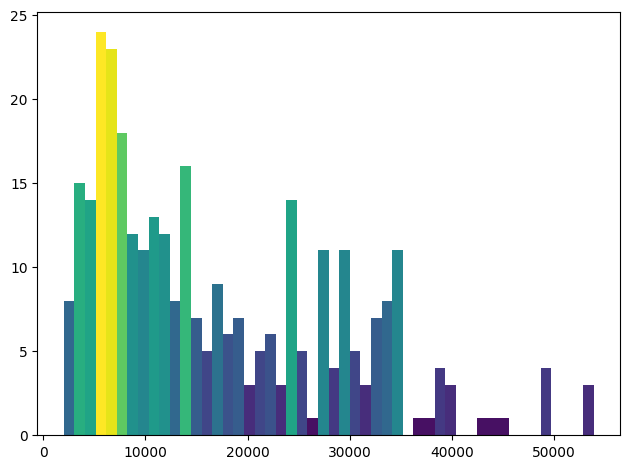

In [ ]:
# Количество кадров в видео
fig, axs = plt.subplots(1, 1, tight_layout=True)
n_bins = 50

N, bins, patches = axs.hist(frame_counts, bins=n_bins)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())

for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
plt.show()

['23', '24', '25', '29', '30']
[1, 1, 182, 104, 36]


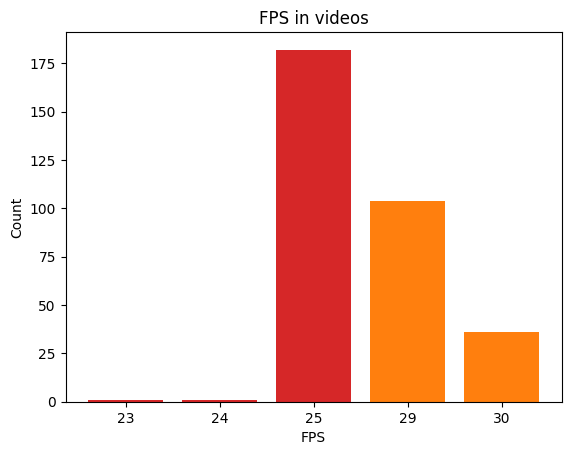

In [67]:
# FPS наших видео
fig, ax = plt.subplots()

good_fpss = [int(x) for x in fpss]
bar_labels = [str(x) for x in np.unique(np.array(good_fpss))]
print(bar_labels)
counts = [good_fpss.count(int(x)) for x in bar_labels]
print(counts)
bar_colors = ['tab:red', 'tab:red', 'tab:red', 'tab:orange', 'tab:orange']

ax.bar(bar_labels, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Count')
ax.set_xlabel('FPS')
ax.set_title('FPS in videos')

plt.show()

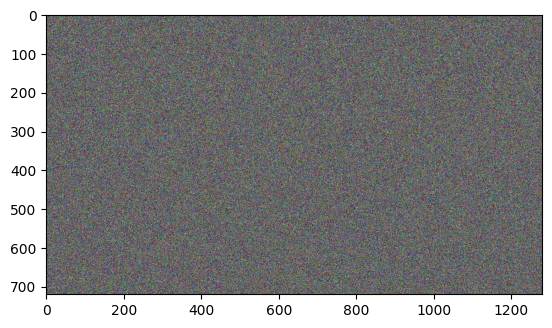

In [ ]:
# Попробуем наложить все кадры друг на друга (спойлер: это ничего не даст)
import matplotlib.pyplot as plt
common_frame = frame_thousands[0]
cfn = 1
for ft in frame_thousands[1:]:
    if ft.shape == (720, 1280, 3):
        common_frame += ft
        cfn += 1
common_frame = common_frame/cfn
plt.imshow(common_frame) # видно, что видео были достаточно тёмными

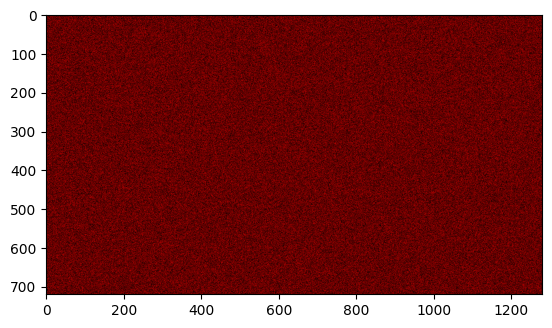

In [70]:
red_matrix = np.array([1,0,0])
plt.imshow(common_frame*red_matrix)

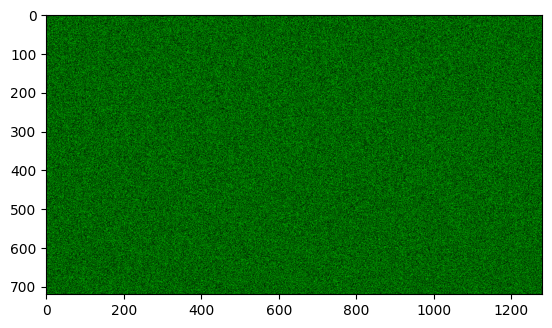

In [71]:
green_matrix = np.array([0,1,0])
plt.imshow(common_frame*green_matrix)

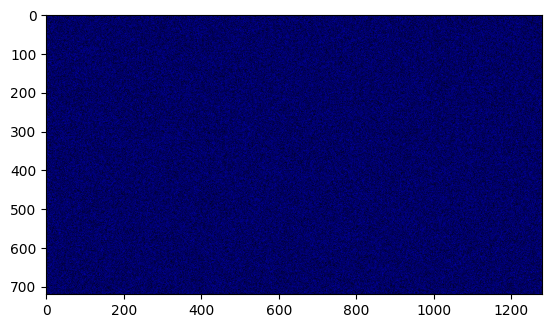

In [72]:
blue_matrix = np.array([0,0,1])
plt.imshow(common_frame*blue_matrix)

### Попробуем наложить кадры одного видео друг на друга

In [85]:
def overlap_video_frames(path_on_disk, path_to_save):
    TOKEN = os.getenv('DEBUG_TOKEN')
    client = yadisk.Client(token=TOKEN)
    client.download(path_on_disk, path_to_save) # скачиваем файл
    cap = cv2.VideoCapture(path_to_save) # читаем файл
    frame_num = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    overlap_frames = np.zeros((720, 1280, 3))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        overlap_frames += frame

    cap.release() # закрываем файл
    return overlap_frames/frame_num

Средний кадр из [этого видео](https://disk.yandex.ru/client/disk/SLR%20Project?idApp=client&dialog=slider&idDialog=%2Fdisk%2FSLR%20Project%2F%D0%91%D0%B0%D0%BD%D0%BA%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B5%20%D0%BA%D0%B0%D1%80%D1%82%D1%8B%20%D0%B4%D0%BB%D1%8F%20%D0%B4%D0%B5%D1%82%D0%B5%D0%B9.%20%D0%A1%20%D1%81%D1%83%D0%B1%D1%82%D0%B8%D1%82%D1%80%D0%B0%D0%BC%D0%B8.mp4) выглядит так:


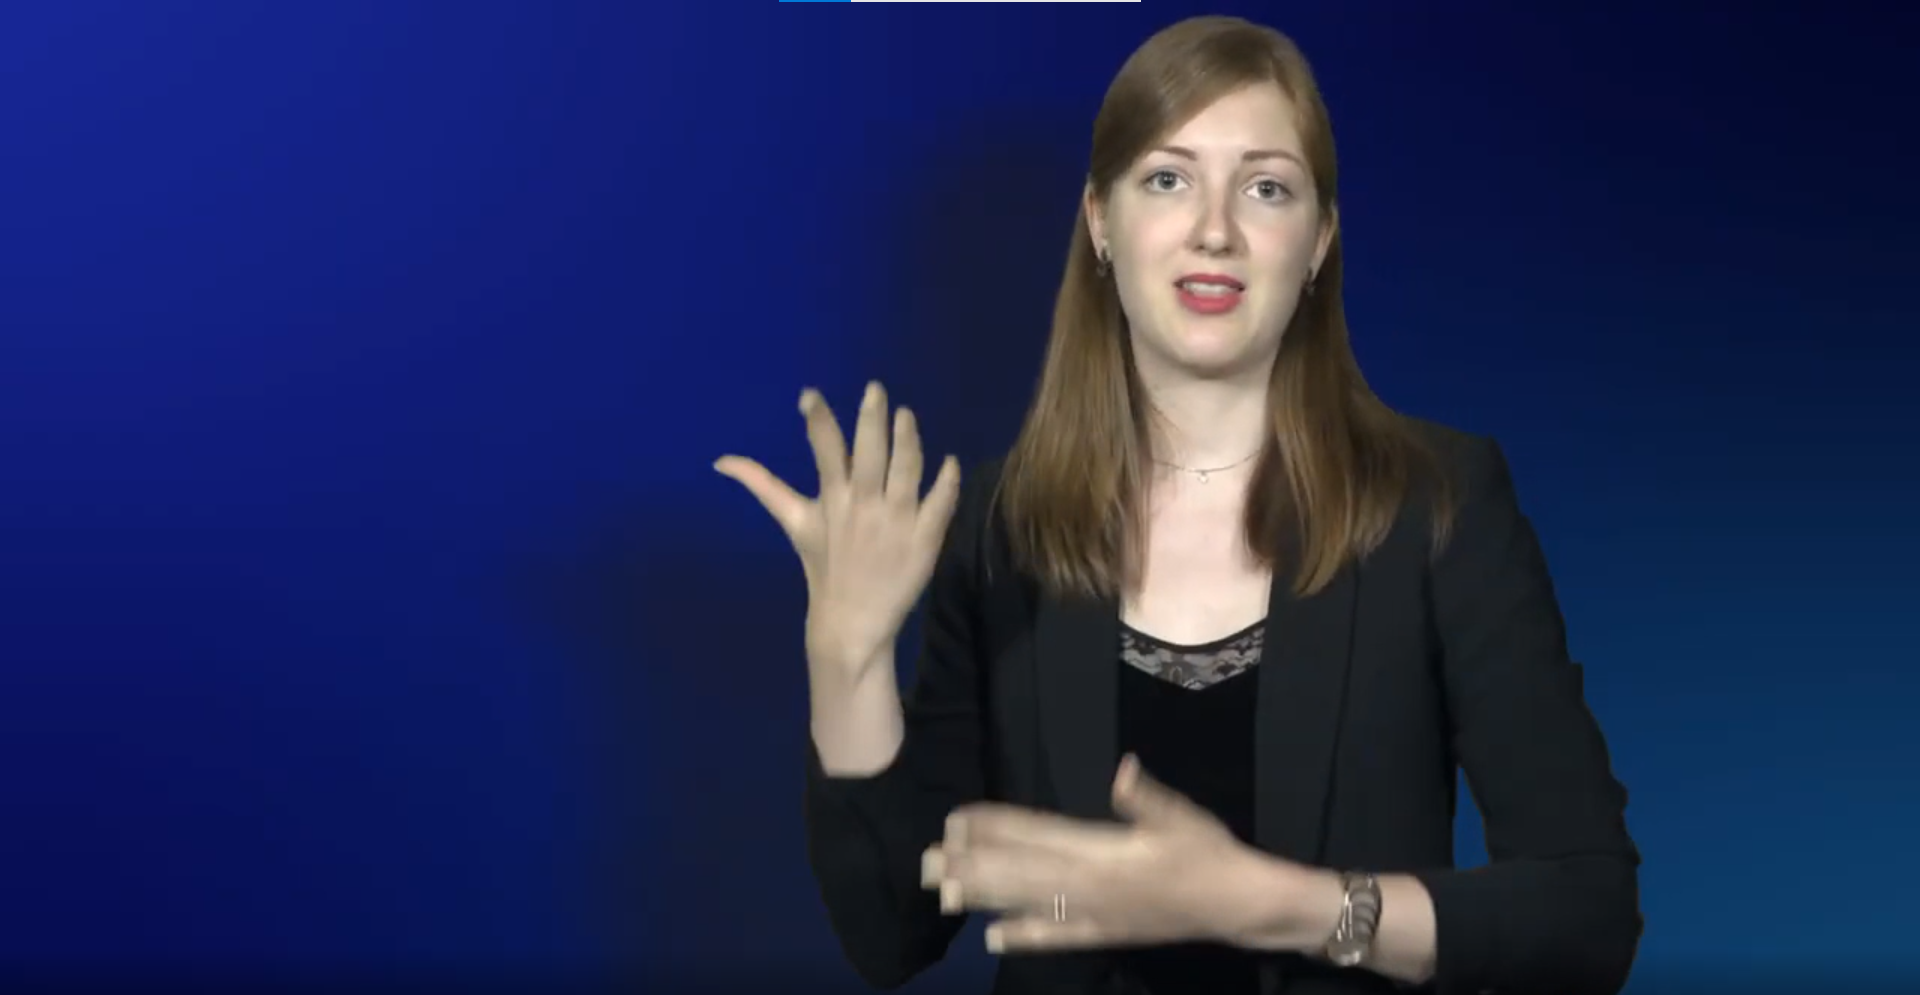

In [ ]:
# А вот это видео в кадрах, наложенных друг на друга:
path_to_save = 'Банковские карты для детей. С субтитрами.mp4'
path_on_disk = 'disk:/SLR Project/' + path_to_save
overlapped_frames = overlap_video_frames(path_on_disk, path_to_save)

In [99]:
# В cv2 картинки изначально в bgr
rgb_overlapped_frames = overlapped_frames.astype(int)
rgb_overlapped_frames[:, :, [2, 0]] = rgb_overlapped_frames[:, :, [0, 2]]

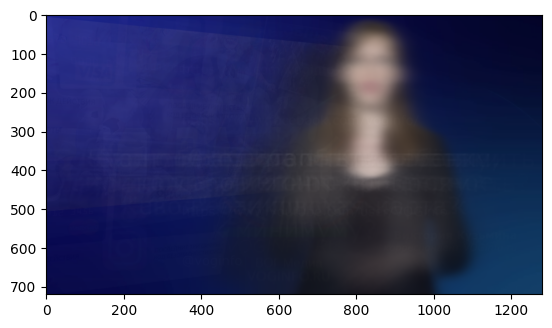

In [ ]:
plt.imshow(rgb_overlapped_frames.astype(int))
# ура, видно лицо, и видно, что был текст на экране